In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools
from scipy.stats import spearmanr
from itertools import combinations

In [3]:
Stage=3
folder_name='experiment and result stage'+str(Stage)
Dataset="Baseline fashion" #if baseline then Basline .../...
baseline='3*3'

if baseline:
  x=Dataset+" "+baseline
  filename="Copy of " + x + "_result.csv"
else:
  filename="Copy of " + Dataset + "_result.csv"

methods=['deeplift', 'integrated_gradients']
method='integrated_gradients'
flops_dict = {"branch1": 56.448, "branch2": 56.448, "branch3": 56.448, "totalFLOPS": 365}
end_epoch=0

In [4]:
load_file_path='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/'+filename
print(load_file_path)
save_folder='/content/drive/My Drive/2023 InterpretingNN/code/'+folder_name+'/'+Dataset+'/processed data/'
print(save_folder)

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline fashion/Copy of Baseline fashion 3*3_result.csv
/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage3/Baseline fashion/processed data/


In [5]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

In [6]:
dataframe

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.0,branch2.0,branch3.0,branch4.0,train accuracy epoch0,test accuracy epoch0,method,run
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,129.876819,124.268005,32.479282,171.491602,85.510000,87.02,deeplift,0
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,129.585725,124.405090,32.443899,171.491617,85.510000,87.02,integrated_gradients,0
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,55.758264,82.477673,80.793915,183.223364,84.920000,87.94,deeplift,1
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,55.402050,82.404889,80.711074,183.223359,84.920000,87.94,integrated_gradients,1
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.657092,71.866418,55.220251,169.577991,85.218333,86.21,deeplift,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,74.885466,60.110432,25.408282,148.688782,85.268333,86.96,integrated_gradients,12
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,45.658261,36.245941,104.207629,154.983447,85.345000,87.74,deeplift,13
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,45.819919,36.105342,104.598966,154.983445,85.345000,87.74,integrated_gradients,13
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,93.257532,21.436629,41.568634,183.766016,85.211667,87.19,deeplift,14


add flops col

In [7]:
def preprocess_dataframe(df, flops_dict):
    df.rename(columns={'branch1.0': 'branch1', 'branch2.0': 'branch2', 'branch3.0': 'branch3', 'branch4.0': 'branch4'}, inplace=True)

    # Add FLOPS columns
    for col, value in flops_dict.items():
        df[col+"FLOPS"] = value
    return df
df = preprocess_dataframe(dataframe, flops_dict)

In [8]:
df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1,branch2,branch3,branch4,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,129.876819,124.268005,32.479282,171.491602,85.510000,87.02,deeplift,0,56.448,56.448,56.448,365
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,129.585725,124.405090,32.443899,171.491617,85.510000,87.02,integrated_gradients,0,56.448,56.448,56.448,365
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,55.758264,82.477673,80.793915,183.223364,84.920000,87.94,deeplift,1,56.448,56.448,56.448,365
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,55.402050,82.404889,80.711074,183.223359,84.920000,87.94,integrated_gradients,1,56.448,56.448,56.448,365
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.657092,71.866418,55.220251,169.577991,85.218333,86.21,deeplift,2,56.448,56.448,56.448,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,74.885466,60.110432,25.408282,148.688782,85.268333,86.96,integrated_gradients,12,56.448,56.448,56.448,365
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,45.658261,36.245941,104.207629,154.983447,85.345000,87.74,deeplift,13,56.448,56.448,56.448,365
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,45.819919,36.105342,104.598966,154.983445,85.345000,87.74,integrated_gradients,13,56.448,56.448,56.448,365
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,93.257532,21.436629,41.568634,183.766016,85.211667,87.19,deeplift,14,56.448,56.448,56.448,365


normalize layer feature attribution in this stack

In [9]:
def normalize_feature_attribution(df, threshold=70):
    layers=['branch1','branch2','branch3','branch4']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']


    df.drop(['sum_feature_attr','branch1','branch2','branch3','branch4'], axis=1, inplace=True)

    # delete data with 70 or lower acc
    epoch_3_accuracy_cols = ['test accuracy epoch'+str(end_epoch)]
    df['final_test_accuracy'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return df

normalized_df = normalize_feature_attribution(df.copy())

In [10]:
normalized_df

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,train accuracy epoch0,test accuracy epoch0,method,run,branch1FLOPS,branch2FLOPS,branch3FLOPS,totalFLOPSFLOPS,norm_branch1,norm_branch2,norm_branch3,norm_branch4,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.510000,87.02,deeplift,0,56.448,56.448,56.448,365,0.283502,0.271259,0.070898,0.374341,87.02
1,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.510000,87.02,integrated_gradients,0,56.448,56.448,56.448,365,0.282984,0.271671,0.070850,0.374496,87.02
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,84.920000,87.94,deeplift,1,56.448,56.448,56.448,365,0.138615,0.205039,0.200853,0.455493,87.94
3,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,84.920000,87.94,integrated_gradients,1,56.448,56.448,56.448,365,0.137905,0.205119,0.200903,0.456073,87.94
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,85.218333,86.21,deeplift,2,56.448,56.448,56.448,365,0.224045,0.187974,0.144434,0.443548,86.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,85.268333,86.96,integrated_gradients,12,56.448,56.448,56.448,365,0.242275,0.194474,0.082203,0.481049,86.96
356,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,85.345000,87.74,deeplift,13,56.448,56.448,56.448,365,0.133858,0.106263,0.305509,0.454370,87.74
357,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,85.345000,87.74,integrated_gradients,13,56.448,56.448,56.448,365,0.134170,0.105723,0.306286,0.453821,87.74
358,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,85.211667,87.19,deeplift,14,56.448,56.448,56.448,365,0.274264,0.063044,0.122250,0.540442,87.19


get standard deviation for each layer's feature attribution

In [11]:
def get_FA_SD(df, method, flops_dict):
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1','norm_branch2','norm_branch3','norm_branch4']
    accuracy_columns = ['train accuracy epoch'+str(end_epoch), 'test accuracy epoch'+str(end_epoch)]

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var = grouped[layers].var()
    std = grouped[layers].std()
    avg_acc = grouped[accuracy_columns].mean()

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'std_{layer}'] = std[layer]

    # Calculate the average normalized variance across the selected layers
    std_layers = [f'std_{layer}' for layer in layers]
    combined_df['avg_std'] = combined_df[std_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
FA_SD = get_FA_SD(normalized_df, method, flops_dict)

In [12]:
FA_SD.to_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")
FA_SD=pd.read_csv(save_folder+"/"+method+" "+Dataset+str(baseline)+" all_FA_SD.csv")

In [13]:
FA_SD

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1,norm_branch2,norm_branch3,norm_branch4,...,std_norm_branch2,std_norm_branch3,std_norm_branch4,avg_std,train accuracy epoch0,test accuracy epoch0,branch1,branch2,branch3,totalFLOPS
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.210592,0.152132,0.163027,0.474249,...,0.073337,0.090611,0.051162,0.073238,85.471222,87.350000,56.448,56.448,56.448,365
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.266796,0.180704,0.205104,0.347396,...,0.076306,0.100785,0.044292,0.080019,85.207778,87.288667,56.448,56.448,56.448,365
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.288464,0.202824,0.225906,0.282806,...,0.070563,0.089246,0.039791,0.071989,84.802000,87.026000,56.448,56.448,56.448,365
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.290677,0.226296,0.242949,0.240078,...,0.056240,0.071983,0.029689,0.056910,84.114111,86.619333,56.448,56.448,56.448,365
4,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.126001,0.109900,0.083038,0.681060,...,0.073235,0.058707,0.044297,0.059653,85.389778,87.040000,56.448,56.448,56.448,365
5,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.166047,0.134444,0.117799,0.581710,...,0.062892,0.045647,0.032560,0.048826,85.517444,87.500000,56.448,56.448,56.448,365
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.215964,0.164657,0.164715,0.454664,...,0.060883,0.066738,0.036682,0.053941,85.411778,87.465333,56.448,56.448,56.448,365
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.261101,0.187849,0.205083,0.345967,...,0.061375,0.076683,0.038588,0.061940,85.000778,87.338000,56.448,56.448,56.448,365
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,8,0.101889,0.083817,0.091480,0.722814,...,0.059827,0.055780,0.034379,0.053398,85.012889,86.384000,56.448,56.448,56.448,365
9,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.139084,0.115275,0.105272,0.640370,...,0.065449,0.045063,0.031149,0.048698,85.363111,87.224667,56.448,56.448,56.448,365


# Graph

In [14]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['std_norm_branch1',	'std_norm_branch2',	'std_norm_branch3',	'std_norm_branch4', 'avg_std']

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


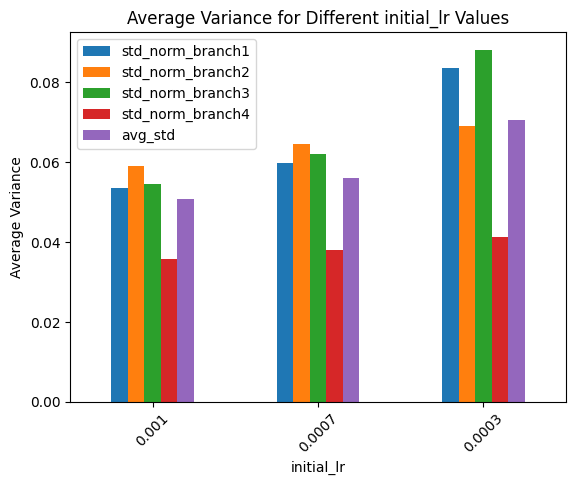

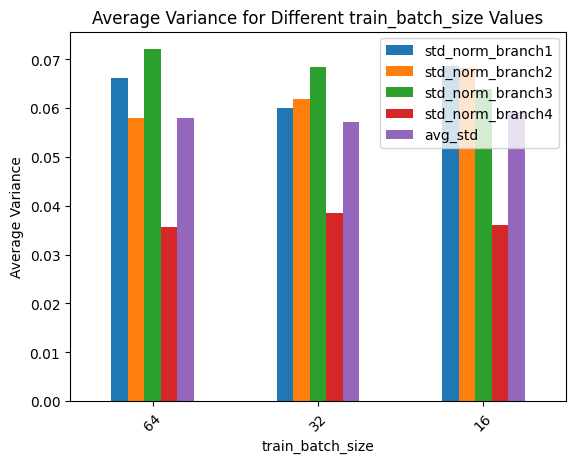

In [15]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(FA_SD, hyperparam, variables)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bee_swarm_for_norm_fa(df, hyperparam, variables):
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = ['norm_branch1', 'norm_branch2', 'norm_branch3', 'norm_branch4']

    # Preparing data for plotting in long format
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var][variance_columns]
        subset = subset.melt(var_name='Branch', value_name='Variance')
        subset[hyperparam] = var
        plot_data = pd.concat([plot_data, subset])

    # Creating the bee swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x=hyperparam, y='Variance', hue='Branch', data=plot_data)
    plt.title(f'Bee Swarm Plot of Variances for Different {hyperparam} Values')
    plt.ylabel('Feature Attribution')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.legend(title='Branch')
    plt.show()


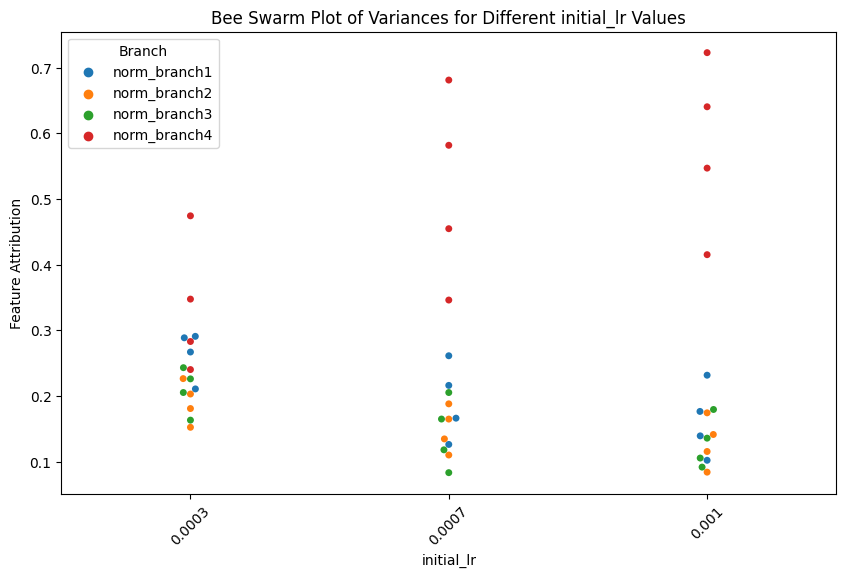

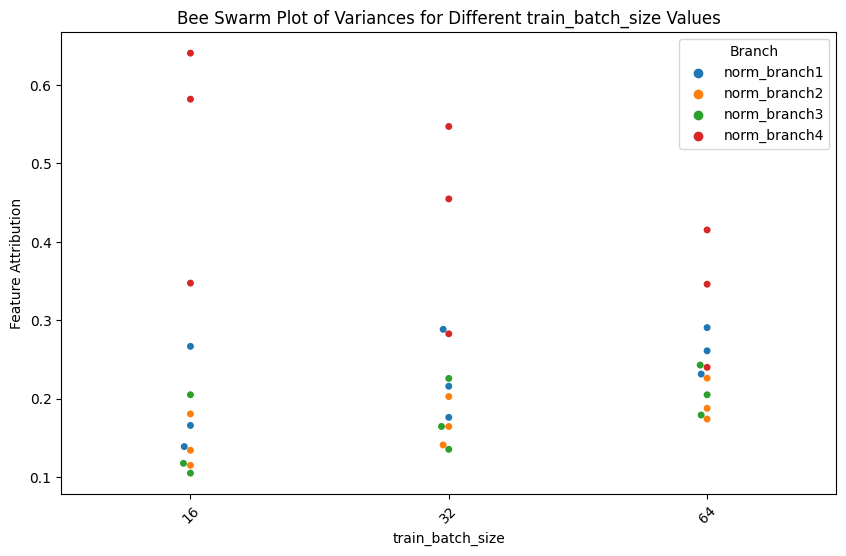

In [17]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_bee_swarm_for_norm_fa(FA_SD, hyperparam, variables)

# Paired T test

In [18]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [19]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [20]:
def generate_hyperparameter_combinations(hyperparams):
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [21]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        #print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

In [22]:
hyperparams_choice_list

{'initial_lr': [0.001, 0.0007, 0.0003], 'train_batch_size': [64, 32, 16]}

In [23]:
def get_significant_results(df, hyperparams_choice_list):
  if not baseline:
    values_to_compare=['std_norm_conv1x1','std_norm_conv1x1_3x3','std_norm_conv1x1_5x5','avg_std']
  else:
    values_to_compare=['std_norm_branch1','std_norm_branch2','std_norm_branch3','avg_std']
  for value in values_to_compare:
    for hyperparam in hyperparams_choice_list:
      lst = hyperparams_choice_list[hyperparam]
      variable_pairs = [(lst[i], lst[j]) for i in range(len(lst)) for j in range(len(lst)) if i != j]
      for variable_pair in variable_pairs:
        data_pairs=get_all_pairs(df, hyperparams_choice_list, value, hyperparam, variable_pair[0], variable_pair[1])
        t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
        #print(value, variable_pair)
        if t_statistic<0:
          #print("not significant\n")
          continue
        if p_value_one_sided>0.01:
          #print("not significant\n")
          continue
        print("Values to compare:", value, "variable_pair:", variable_pair, "T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)
    print("\n")

In [24]:
get_significant_results(FA_SD, hyperparams_choice_list)

#layer feature attribution rank frequency comparison

In [25]:
normalized_df_highacc = normalized_df[normalized_df['method'] == method]

In [26]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']


In [27]:
cols_of_interest = ['norm_branch1', 'norm_branch2', 'norm_branch3','norm_branch4']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-27-799ba4b3762b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


3214    34
3124    33
2134    30
2314    22
1234    16
1324    11
2143     9
4213     7
4123     5
4312     4
3142     2
4132     2
1423     1
3412     1
2413     1
4321     1
1243     1
Name: rank_combination, dtype: int64